In [2]:
import importlib
import sys, time

try:
    importlib.reload(sys.modules['DMlensing'])
    from DMlensing import *
except:
    from DMlensing import *

## Ray
import ray
ray.shutdown()
ray.init(num_cpus=12, ignore_reinit_error=True)

2023-04-14 16:26:45,261	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.10
Ray version:,2.3.1
Dashboard:,http://127.0.0.1:8266


In [3]:
# Set simulation environments
test_num = 1000     # total number of simulations
dat_num = 300       # n     {(t1, x1), ... (tn, xn)}
k_num = 100         # N_k   {k1, k2, ... k_Nk}, {phi1, ... phi_Nk}
ob_time = ly        # Total observation time for each detection (1 year)  
theta_ = 2*pi*ob_time/ly    # Detectors moves along the Earth orbit
# print(f"theta: ", theta_)

t_data = np.linspace(0,ob_time,dat_num) 
theta_data = np.linspace(0, theta_, dat_num) 
x_data = (AU/c)*np.array( [[cos(theta), cos(pi/3)*sin(theta), sin(pi/3)*sin(theta)] for theta in theta_data])


## Without lensing, only no lens case

data, covariance matrix are set.
elapse time: 0.1
test_num = 990 / 1000,	elapsed time:2.1

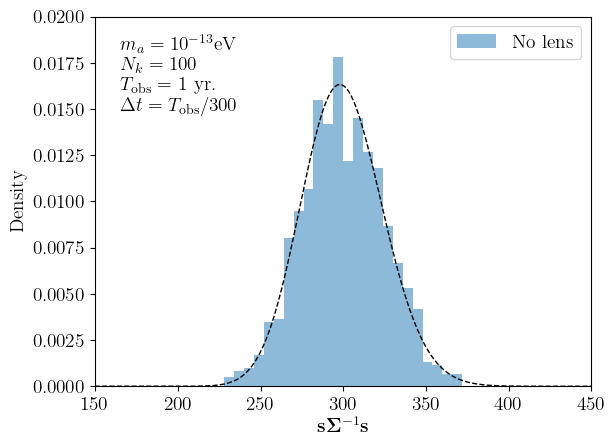


Done


In [5]:
#########################  Test simulation #######################
timestamp = time.time()

result_list = np.zeros(test_num)

data = DMRandomGenerator(t_data, x_data, k_num=k_num, seed=None)
test = stochasticDM(data=data, mpmath=False)

print(f"data, covariance matrix are set.\nelapse time: {time.time()-timestamp:.1f}")

for i in range(test_num):
    data = DMRandomGenerator(t_data, x_data, k_num=k_num, NO_LENSING=True, INCLUDE_LENSING=False, seed = i*4152)
    test.data = data

    result_list[i] = test.Log_likelihood(lensed=False)
    if i%10==0: print(f"\rtest_num = {i} / {test_num},\telapsed time:{time.time()-timestamp:.1f}", end='')

########################## Plot #####################3############

start = 150
end = 450

fig, ax = plt.subplots()

ax.hist(result_list, range=[start, end], bins=50, density=True, alpha=.5, label="No lens")

x_list = np.linspace(0,2*dat_num, 501)
ax.plot(x_list , chi2.pdf(x_list, df=dat_num), linestyle='--', linewidth=1, color='k')
ax.set_xlim(start, end)
ax.set_ylim(0,0.02)
ax.set_xlabel("$\\mathbf{s}\\mathbf{\\Sigma}^{-1}\\mathbf{s}$")
ax.set_ylabel("Density")
ax.legend()
ax.text( ax.get_xlim()[1]*0.05 + ax.get_xlim()[0]*0.95,
        ax.get_ylim()[1]*0.95,
        "$m_a = 10^{-13}$eV\n\
            $N_k=100$\n\
            $T_{\\rm obs} =$ 1 yr.\n\
            $\\Delta t = T_{\\rm obs}/300$",
        verticalalignment='top', horizontalalignment='left')
plt.show()
# plt.savefig(f'result/signal.jpg', dpi=600, bbox_inches='tight')
print("\nDone")
# #####################################################################

## Comparing with / without lensing

* The computation time for amplification is very large.
(For the given simulation setting, the total calculation time > 10 min. in my computer.)
* In this code, setting $\Delta t \ll T_{\rm coh}$ does not give proper results. Since det $(\Sigma)$ is extremely small, its inverse matrix can not be calculated correctly.

data, cov mat set. elapse time: 0.6
test_num = 990 / 1000,	elapsed time:657.4
Done


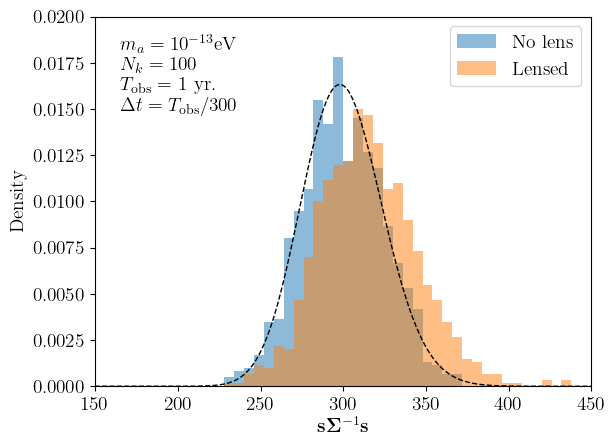

In [2]:
#########################  Test simulation #######################
timestamp = time.time()

result_list = np.zeros(test_num)
result_lensing_list=np.zeros(test_num)

data = DMRandomGenerator(t_data, x_data, k_num=k_num, seed=None)
test = stochasticDM(data=data, mpmath=False)

print(f"data, covariance matrix are set.\nelapse time: {time.time()-timestamp:.1f}")

for i in range(test_num):
    data = DMRandomGenerator(t_data, x_data, k_num=k_num, NO_LENSING=True, INCLUDE_LENSING=True, seed = i*4152)
    test.data = data

    result_list[i] = test.Log_likelihood(lensed=False)
    result_lensing_list[i] = test.Log_likelihood(lensed=True)
    if i%10==0: print(f"\rtest_num = {i} / {test_num},\telapsed time:{time.time()-timestamp:.1f}", end='')

########################## Plot #####################3############

start = 150
end = 450

fig, ax = plt.subplots()

ax.hist(result_list, range=[start, end], bins=50, density=True, alpha=.5, label="No lens")
ax.hist(result_lensing_list, range=[start, end], bins=50, density=True, alpha=.5, label="Lensed")

x_list = np.linspace(0,2*dat_num, 501)
ax.plot(x_list , chi2.pdf(x_list, df=dat_num), linestyle='--', linewidth=1, color='k')
ax.set_xlim(start, end)
ax.set_ylim(0,0.02)
ax.set_xlabel("$\\mathbf{s}\\mathbf{\\Sigma}^{-1}\\mathbf{s}$")
ax.set_ylabel("Density")
ax.legend()
ax.text( ax.get_xlim()[1]*0.05 + ax.get_xlim()[0]*0.95,
        ax.get_ylim()[1]*0.95,
        "$m_a = 10^{-13}$eV\n\
            $N_k=100$\n\
            $T_{\\rm obs} =$ 1 yr.\n\
            $\\Delta t = T_{\\rm obs}/300$",
        verticalalignment='top', horizontalalignment='left')
# plt.show()
plt.savefig(f'result/signal.jpg', dpi=600, bbox_inches='tight')
print("\nDone")
# #####################################################################